<h1><b>Statistique en Bioinformatique : </b> TME9 </h1><br>

L’objectif de ce TME est l'implementation de la méthode Expectation-Maximisation pour la recherche de motifs.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p><b>Soumission</b></p>
<ul>
<li>Renomer le fichier TME9.ipynb pour NomEtudiant1_NomEtudiant2.ipynb </li>
<li>Soumettre via moodle </li>
</div>

<H1>Expectation-Maximisation Motif</H1>
<br>
La méthode EM (Expectation-Maximisation) permet de détecter des motifs dans un ensemble de séquences ADN ou protéiques reliées, non alignées. En particulier, étant donné un groupe de séquences de longueur $L$, dont on sait qu'elles partagent un motif commun de longueur $w$, l’algorithme EM:
- infère un modèle $(\Theta,Z)$ pour le motif;
- localise l’occurrence du motif dans chaque séquence.

$\Theta$ representé la matrice des poids-positions $p_{c,k}$ du motif (où $c \in \{A,C,G,T\}$ ou $c \in \{A,C,D,...,W\}$  et $k \in \{0 \dots w\}$), $p_{c,0}$  est le vecteur de probabilités du modèle nul ou "background".
$Ζ$ est la matrice des variables cachées, qui donnent les positions initiales du motif: 
- $Z_{i,j} = 1$, si le motif commence en position $j$ de la séquence $i$,
- $Z_{i,j} = 0$, sinon. 

L’algorithme affine les paramètres du modèle de manière itérative par espérance-maximisation. Chaque itération $t$ se compose de deux étapes:
- (E) Calcul des valeurs attendues $Ζ^{(t)}$ de $Ζ$, étant donnés $\Theta^{(t-1)}$
- (M) Estimation de  $\Theta^{(t)}$  à partir de  $Ζ^{(t)}$

1\. Implémentez une fonction `read_training_file` pour lire le fichier d'entré qui contient un ensemble de séquences ADN non alignées. Pour simplifier nous allons utiliser les données vu en cours du fichier `toyEx.txt`.

In [394]:
import numpy as np
import matplotlib.pyplot as plt
import random

nts = ['A', 'C', 'G', 'T']

w = 3
input_f = "toyEx.txt"

def read_training_file(input_f):
    """
    Read a file with no-aligned sequences
    input input_f : file name
    output seqs : list of sequences
    """
    seqs = []
    with open(input_f, 'r') as f:
        for line in f:
            seqs.append( line.rstrip('\n') )
    return seqs

seqs = read_training_file(input_f)
print (seqs) #['GTCAGG', 'GAGAGT', 'ACGGAG', 'CCAGTC']

['GTCAGG', 'GAGAGT', 'ACGGAG', 'CCAGTC']


2\. Implémentez une fonction `initialiseP` pour initialiser la matrice poids-position $p_{c,k}$. On considère le modèle nul par défaut $p_0 = (0.25, 0.25, 0.25, 0.25)$. Pour initialiser $p^{(t)}$, on prend généralement un motif au hasard dans une sequence, et on fixe à $0.5$ les poids du nucleotide correspondant et à $\frac{1-0.5}{3}$ les trois autres. 

In [395]:
def initialiseP(seqs, w, alph):
    """
    Initialise pc,k
    input seqs : list of sequences
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output P: position probability matrix
    """
    
    
    q=len(alph)
    nts = ['A', 'C', 'G', 'T']
    
    #Initialisation de P
    P = np.zeros((q, w+1))
    
    #Première colonne à 0.25
    P[:,0] = np.ones(q) * (1/(q))
    
    for t in range(1,w+1):
        #Tirage d'une sequence aléatoire
        seq_h = seqs[random.randint(0,len(seqs)-1)]
        
        #Tirage d'un nt aléatoire
        nt_h = seq_h[random.randint(0,len(seq_h)-1)]
        
        #Mise à jour des autres
        P[ :, t] = (np.ones(q)-0.5)/3
        
        #Mise a jour avec nt
        P[ nts.index(nt_h), t] = 0.5
   
    return P

#test
p = initialiseP(seqs, w, nts)
print (p)

[[0.25       0.16666667 0.16666667 0.5       ]
 [0.25       0.16666667 0.16666667 0.16666667]
 [0.25       0.16666667 0.5        0.16666667]
 [0.25       0.5        0.16666667 0.16666667]]


3\. Implémenter une fonction `initialiseZ` pour initialiser la matrice $Z$ à uns. Rappelez-vous que la dimension de $Z$ est $nbSeq \times (lenSeq -w +1)$, où $nbSeq$ est le nombre de sequences et $lenSeq$ est la taille/longueur des sequences.

In [396]:
def initialiseZ(seqs, w):
    """
    Initialise Z
    input seqs : list of sequences
    input w : motif length
    output Z :  matrix of motif start positions
    """
    
    #initialisation
    Z = np.zeros((len(seqs),len(seqs[0])-w+1))
    
    #Affectation de 1
    for s in range(len(seqs)):
        Z[s,random.randint(0,len(seqs[0])-w)] = 1
    return Z

Z = initialiseZ(seqs, w)
print(Z)

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


4\. Écrivez une fonction `E_step` pour le pas Expectation qui estime $Z$ à partir de  $p_{c,k}$. 
Écrivez aussi une fonction `normaliseZ` pour normaliser $Z$.

In [397]:
def E_step(seqs, P, Z, w, alph):
    """
    Implement Expectation step
    input seqs : list of sequences
    input P : position probability matrix
    input Z :  matrix of motif start positions
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output Z :  matrix of motif start positions
    """  
    
    #Initialisation de Z
    #Z = initialiseZ(seqs, w)
    
    #Initialisation de new_Z
    new_Z = np.ones(Z.shape)
    nts = ['A', 'C', 'G', 'T']

    #Parcours sur chaque sequence
    for i in range(len(seqs)):
        #Parcours sur chaque nt de la séquence
        for j in range(len(Z[0])):
            #Parcours sur chaque porrtion de séquence
            for k in range(0, j):
                index = nts.index(seqs[i][j])
                new_Z[i,j] *= P[ index, 0 ]
            for k in range(j, w):
                index = nts.index(seqs[i][j])
                new_Z[i,j] *= P[ index, k]
            for k in range(w, len(seqs[0])):
                index = nts.index(seqs[i][j])
                new_Z[i,j] *= P[ index, 0]
    
    return new_Z

def normaliseZ(z):
    """
    Normalise Z matrix
    input Z : unnormalised matrix
    output Zn : normalised matrix
    """
    return np.array([row/sum(row) for row in z])
    
Z = E_step(seqs, p, zbis, w, nts)
z_norm = normaliseZ(Z)
print(z_norm)

[[0.30769231 0.30769231 0.15384615 0.23076923]
 [0.27906977 0.09302326 0.41860465 0.20930233]
 [0.11428571 0.11428571 0.51428571 0.25714286]
 [0.17391304 0.17391304 0.26086957 0.39130435]]


5\. Implémentez une fonction `M_step` pour le pas Maximisation qui estime $p_{c,k}$ à partir de $Z$. 
Utilisez les "pseudocounts" pour éviter les probabilités ègales à zero.

In [398]:
def totalNumberofCH(seqs,alph):
    q = len(alph)
    totalN = np.zeros((q))
    for i in range(q):
        e = alph[i]
        for seq in seqs:
            for s in seq:
                if(s == e):
                    totalN[i]+=1
    return totalN
                    
def M_step(seqs, Z, w, alph):
    """
    Implement Expectation step
    input seqs : list of sequences
    input Z :  matrix of motif start positions
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output P : position probability matrix
    """
    #Mise de chaque valeur à 1
    P = np.ones((len(seqs), len(seqs[0])-w+1))
    
    
    totalN = totalNumberofCH(seqs, alph)
    nts = ['A', 'C', 'G', 'T']
    for seq_i,seq in enumerate(seqs):
        all_motifs = [seq[k:k+w] for k in range(len(seq)-w+1)]
        
        for pos_m,motif in enumerate(all_motifs):
        
            for pos_n,nt in enumerate(motif):
                index = nts.index(nt)
                P[index, 1+pos_n] += Z[seq_i, pos_n]

    return P/np.sum(P,axis=0)
    
P = M_step(seqs, z_norm, w, nts)

print(P)

[[0.25       0.28721008 0.26376968 0.25      ]
 [0.25       0.23597881 0.23623032 0.15065514]
 [0.25       0.30244849 0.28068672 0.4204952 ]
 [0.25       0.17436262 0.21931328 0.17884966]]


6\. Écrivez une fonction `likelihood` qui calcule la log-vraisemblance de l'ensemble des sequences.

In [399]:
def likelihood(seqs, Z, P, w, alph):
    """
    Implement log likelihood function of P
    input seqs : list of sequences
    input Z :  matrix of motif start positions
    input p : position probability matrix
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output lLikelihood : log likelihood of P 

    """
    M = len(seqs)
    L = len(seqs[0])

    lLikelihood = np.log((L-w+1)**-M)
    lLikelihood += np.sum(np.log([np.sum(z) for z in Z]))
    
    return lLikelihood

logvraisemblance = likelihood(seqs, Z, P, w, nts)
print(logvraisemblance)

-33.48953638146004


7\. Implémentez l'algorithme Expectation-Maximisation. Vous calculerez la valeur de la log-vraisemblance totale du modèle à chaque iteration et l'algorithme prendra fin lorsque $\Delta \log \text{Pr}(D | \Theta) < \varepsilon$. Utilisez $\varepsilon = 1e-4$. Votre implementation devra renvoyer les paramètres du modele ($p$ et la log-likelihood associé), ainsi bien que la liste des meilleures positions du motif dans chaque sequence (matrice $Z$). Faites attention à utiliser $Z$ non-normalisé afin de trouver la log-vraisemblance!

Les paramètres du modele:
p:
 [[0.25       0.25006104 0.25006101 0.25      ]
 [0.25       0.24999993 0.24993899 0.24987799]
 [0.25       0.25012204 0.25012197 0.25024398]
 [0.25       0.249817   0.24987803 0.24987803]]


log-vraisemblance associé: -33.2705767541646


Z:
 [[0.00024438 0.00024384 0.00024408 0.00024414]
 [0.00024438 0.00024426 0.00024426 0.00024414]
 [0.00024426 0.00024408 0.00024426 0.00024414]
 [0.00024408 0.00024408 0.0002442  0.00024414]]

Les motifs:
seq1: 1  GTC
seq2: 1  GAG
seq3: 1  ACG
seq4: 3  AGT


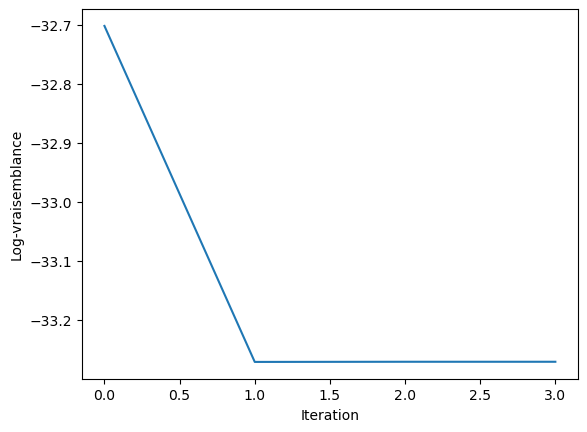

In [400]:
def ExpectationMaximisation(seqs, w, alph, eps):
    """
    Implement Expectation Maximisation algorithm
    input seqs : list of sequences
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    input eps : threahold 
    output P : position probability matrix
    output Z :  matrix of motif start positions
    output lLikelihood : log likelihood of P 
    output pos_motif : positions of motifs in seqs
    """
    P = initialiseP(seqs, w, alph)
    Z = initialiseZ(seqs, w)
    lLikelihood = []
    pos_motif = []
    
    #Infini pour éviter les erreurs
    stop = np.inf
    
    #Boucler jusqu'à atteindre epsilon
    while stop>=eps:
        #Expectation
        Z = E_step(seqs,P,Z,w,alph)
        
        #Maximization
        P = M_step(seqs,Z,w,alph)
        
        #Calcul du log-vraisemblance et mise a jour du stop
        lLikelihood.append(likelihood(seqs,Z,P,w,alph))
        if len(lLikelihood)>=2:
            stop = np.abs(lLikelihood[len(lLikelihood)-2] - lLikelihood[len(lLikelihood)-1])
    
    #Récupération des meilleurs positions de motif
    for s in range(len(seqs)):
        pos_motif.append(np.argmax(Z[s]))

    return (P, lLikelihood, Z, pos_motif)

def analyse_results(results, seqs):
    print('Les paramètres du modele:')
    print('p:\n',results[0])
    print('\n')
    print('log-vraisemblance associé:',results[1][-1])
    print('\n')
    print('Z:\n',results[2])
    print('\nLes motifs:')
    for i in range(len(seqs)):
        print('seq'+str(i+1)+': '+ str(results[3][i]+1) + '  ' + seqs[i][results[3][i]:results[3][i]+w])

    plt.plot(results[1])
    plt.xlabel('Iteration')
    plt.ylabel('Log-vraisemblance')
    plt.show()

eps = 10**-4
EMResults = ExpectationMaximisation(seqs, w, nts, eps)
analyse_results(EMResults,seqs)

8\. Qu'est-ce que vous observez en exécutant l'algorithme EM plusieurs fois? Justifiez votre réponse.

Reponse:

<font color="blue">

</font>

9\. Pour éviter le problème identifié au point précedent, écrivez une fonction `EM_iteratif` qui exécute l'algorithme `EM` $N$ fois ($N=10$) et qui prend les paramètres associés à la meilleure log-vraisemblance. Trouvez-vous les bons motifs?

Les paramètres du modele:
p:
 [[0.25       0.25002709 0.25002707 0.25      ]
 [0.25       0.25021673 0.24997293 0.2499187 ]
 [0.25       0.25005418 0.25027068 0.2502439 ]
 [0.25       0.24970199 0.24972932 0.2498374 ]]


log-vraisemblance associé: -33.270576754083066


Z:
 [[0.00010851 0.00010851 0.00048828 0.00024414]
 [0.00010851 0.00010851 0.00016276 0.00024414]
 [0.00010851 0.00097656 0.00016276 0.00024414]
 [0.00097656 0.00097656 0.00016276 0.00024414]]

Les motifs:
seq1: 3  CAG
seq2: 4  AGT
seq3: 2  CGG
seq4: 1  CCA


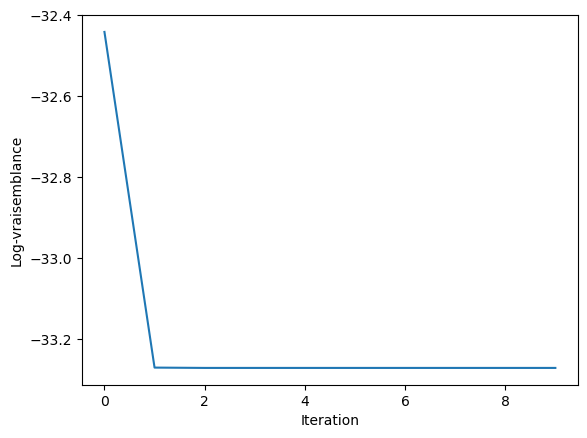

In [401]:
def EM_iteratif(N, seqs, w, alph, eps):
    """
    Implement a iterative version of Expectation Maximisation algorithm
    input N : number of iterations
    input seqs : list of sequences
    input w : motif length
    input eps : threahold 
    output bestModel : the parameter of the best model
    """
  
    #Initialisation des paramètres
    P = initialiseP(seqs, w, alph)
    Z = initialiseZ(seqs, w)
    top_lLikelihood = []
    top_P = []
    top_Z = []
    pos_motif = []
    
    #Boucler jusqu'à atteindre epsilon
    for n in range(N):
        #Expectation
        Z = E_step(seqs,P,Z,w,alph)
        top_Z.append(Z)
        
        #Maximization
        P = M_step(seqs,Z,w,alph)
        top_P.append(P)
        
        #Calcul du log-vraisemblance et mise a jour du stop
        log_like_actuel = likelihood(seqs,Z,P,w,alph)
        top_lLikelihood.append(log_like_actuel)
        
        if len(top_lLikelihood)>=2:
            stop = np.abs(top_lLikelihood[len(top_lLikelihood)-2] - top_lLikelihood[len(top_lLikelihood)-1])
        
        #Récupération des meilleurs positions de motif
        pos_motif.append([np.argmax(Z[s]) for s in range(len(seqs))]) 

    #Récupération des top_valeurs
    lLikelihood = max(top_lLikelihood)
    Z = top_Z[np.argmax(lLikelihood)]
    P = top_P[np.argmax(lLikelihood)]
    pos_motif = pos_motif[np.argmax(lLikelihood)]

    bestModel = P, top_lLikelihood, Z,pos_motif

    return bestModel


eps = 10**-4
N=10
meilleurEM = EM_iteratif(N, seqs, w, nts, eps)
analyse_results(meilleurEM,seqs)

10\. Appliquez votre algorithme `EM` à l'ensemble des séquence du fichier `trainingSequences.txt` en utilisant $w=10$. 

['ACAACCATATATAGTAGCCACTGAAT', 'CCACCCCATATATAGTACGGGTGGTG', 'CCATAAATAGAGCAGACTGTCGCTGT', 'GTAAACATAAAACCCCATAAATAGGA', 'TTCAAGAAACTGCCATAAATAGCGAT', 'TAGAGGTTTTTGTGCCATAAATAGGT', 'CCCCATAAATAGGAATATCGGCCTGA', 'TTGCCATTAAATTATACCATATATGG', 'TATCAACAACGATAACCCATATATGG', 'TTTCCAAATATAGAAGGTGTGGAAAG', 'TCCAAATATAGTAAAATCGAGTCGAT', 'GACTGGGGCCCAAATATAGCATGTTC', 'ATCATTAGCTTTTACTCCATAAATGG', 'ATTCTTTTGCCATAAATGGTAACTCG', 'CCATAAATGGCAAGTCTGTCGAATAA', 'CCCATAAATGGCAGGGTATTAGCACG', 'CCAAAAATAGTGTGTCGTAACAGCTT', 'CCAAAAATAGGGGAATGGAAGTGGGG', 'CCAAAAATAGGCCAGAGTTTACAACG', 'CCAAAAATAGTTAAATAATATACATT', 'CTACACCTTCCAAAAATAGTATATCT', 'TTGCCAAATATGGGGTTAGAGTGTTC', 'GTCTTTACCAAAAATGGTGATCCTGT', 'TTGCCAAAAATGGAGCGTTTACCAAT', 'ATCCACCATTTATAGATTCAGGAGGC', 'GCATAAGAGAACATTCCATTTATAGG', 'TCAACCCCATTTATAGCCACGTCAGT', 'CATCCATTAATAGTAGCCTAATGGCG', 'GGAGTAGGCCCATTAATAGTATCTTT', 'CCATTAATAGACAAAATCGACTCAAG', 'CCAATTATAGAAAGTGGCTGGTCGTC', 'AACTATTATTTCTCACCCATTAATGG', 'ATGCTTTACCAATAATAGAGCTGCAA', 'GGTCAGTT

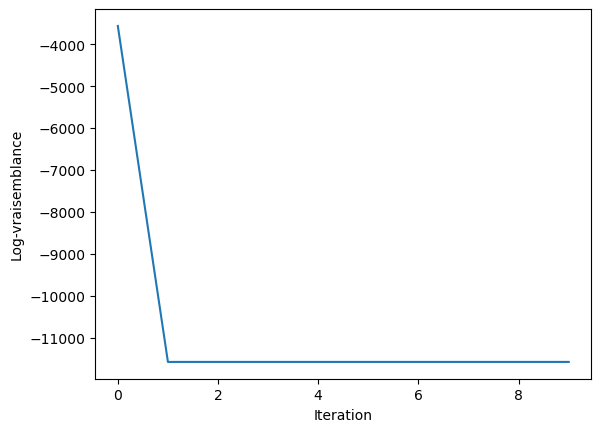

In [424]:
w= 10
input_f = "trainingSequences.txt"
seqs_train = read_training_file(input_f)
print (seqs_train)
eps = 10**-4
N=10
meilleurEM = EM_iteratif(N, seqs_train, w, nts, eps)
analyse_results(meilleurEM,seqs_train)

11\. Construire un LOGO pour le motif prédit avec le service <i>WebLogo</i>. Pour cela, identifiez le motif dans chaque séquence, utiliser <i>ClustalOmega</i> pour les aligner et puis <i>WebLogo</i> pour générer le LOGO. Ajouter le LOGO à votre réponse.

In [425]:
fhandler = open('motifs.txt','w')
for i in range(len(seqs_train)):
    fhandler.write('>motif'+str(i+1)+'\n')
    fhandler.write(seqs_train[i][meilleurEM[3][i]:meilleurEM[3][i]+w])
    fhandler.write('\n')
fhandler.close()

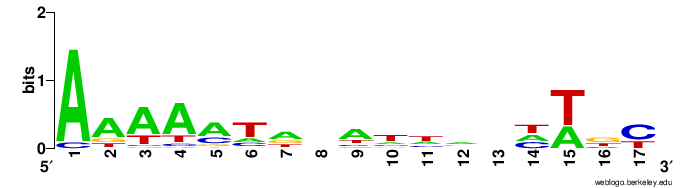

12\. Comparez les motifs trouvés par votre programme avec les motifs du fichier `testingSequences.txt`, où les vrais motifs sont montrés en lettre majuscule. Quelle est la performance de votre programme? 

In [426]:
import re

input_f = "testingSequences.txt"

motifs_extracted = []
motifs_real = []

#Récuperation des séquences
with open("motifs.txt","r" ) as file:
    contenu = file.read()
    pattern = r'\w+\n(\w+)'
    motifs_extracted = re.findall(pattern,contenu)

#Extraction des parties en Majuscules 
with open(input_f,"r" ) as file:
    contenu = file.read()
    pattern = r'[A-Z]+'
    motifs_real = re.findall(pattern,contenu)



In [427]:
total = len(motifs_extracted)
count = 0
for i in motifs_extracted:
    for j in motifs_real:
        if i==j:
            count+=1
            
print(count/total)

0.1134020618556701
